# Чтение и предобработка данных 

In [4]:
import pandas as pd
fake = pd.read_csv('Fake.csv') 
not_fake = pd.read_csv('True.csv') 

In [5]:
fake.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [6]:
fake.shape

(23481, 4)

In [ ]:
not_fake.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [7]:
not_fake.shape

(21417, 4)

In [10]:
#df = pd.concat([fake, not_fake])
#df.head(2)

In [11]:
# Берем только Fake
df = fake

In [12]:
df.tail(2)

,title,text,subject,date
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


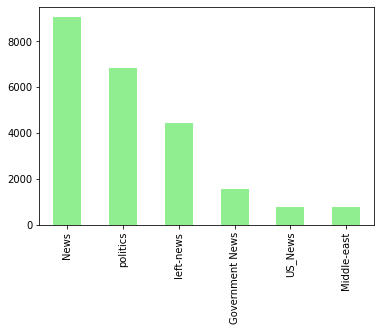

In [13]:
df['subject'].value_counts().plot.bar(color='lightgreen')

In [14]:
df['concat_text'] = df['title'] + ' ' + df['text']

In [15]:
y_train = df['subject']
X_train = df.drop(['date', 'subject'],axis=1)
X_train = X_train.reset_index(drop=True)

y_test = df['subject']
X_test = df.drop(['date', 'subject'],axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

In [ ]:
import numpy as np

print(np.bincount(y_train))
print(le.inverse_transform([i for i in range(5)]))

[1570  778 9050  783 4459 6841]
['Government News' 'Middle-east' 'News' 'US_News' 'left-news']


In [ ]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') 
  for sl in x for i in sl if i is not ''])


<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-66-f79bf1dffd22>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  for sl in x for i in sl if i is not ''])


In [ ]:
X_train['pr_text'] = preprocess(X_train['concat_text'])
X_test['pr_text'] = preprocess(X_test['concat_text'])

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [70]:
X_train['text'].to_csv('xtrain.csv')

In [ ]:
X_test['text'].to_csv('xtest.csv')

In [71]:
from sklearn.model_selection import train_test_split

# Класс C-LSTM

In [69]:
import tensorflow as tf


class CLSTM():
    
    def __init__(self):
        self.max_length =0
        self.num_classes = 2
        self.vocab_size = 0
        self.embedding_size = 256
        self.filter_sizes = [3, 4, 5]
        self.num_filters = 128
        self.hidden_size = len(self.filter_sizes) * self.num_filters
        self.num_layers = 2
        self.l2_reg_lambda = 0.001 
        self.batch_size = 32
        self.input_x = X_train
        self.input_y = y_train
        self.sequence_length = 256

        # L2 loss
        self.l2_loss = tf.constant(0.0)

        # Эмбеддинги
        with tf.device('/cpu:0'), tf.compat.v1.variable_scope('embedding'):
            embedding = tf.Variable(tf.compat.v1.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                                    name="embedding")
            embed = tf.nn.embedding_lookup(embedding, 
                            np.asarray(embedding, dtype=np.int32))
            inputs = tf.expand_dims(embed, -1)


        conv_outputs = []
        max_feature_length = self.max_length - max(self.filter_sizes) + 1
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.compat.v1.variable_scope('conv-%s' % filter_size):
                filter_shape = [filter_size, self.embedding_size, 1, self.num_filters]
                W = tf.compat.v1.get_variable('weights', filter_shape, initializer=tf.random.truncated_normal(stddev=0.1))
                b = tf.compat.v1.get_variable('biases', [self.num_filters], initializer=tf.constant_initializer(0.0))

                conv = tf.nn.conv2d(inputs,
                                    W,
                                    strides=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='conv')
                # Функция активации
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name='relu')
                h_reshape = tf.squeeze(h, [2])
                h_reshape = h_reshape[:, :max_feature_length, :]
                conv_outputs.append(h_reshape)

       
        if len(self.filter_sizes) > 1:
            rnn_inputs = tf.concat(conv_outputs, -1)
        else:
            rnn_inputs = h_reshape

        cell = tf.contrib.rnn.LSTMCell(self.hidden_size,
                                       forget_bias=1.0,
                                       state_is_tuple=True,
                                       reuse=tf.tf.compat.v1.variable_scope().reuse)

        cell = tf.contrib.rnn.MultiRNNCell([cell]*self.num_layers, state_is_tuple=True)

        self._initial_state = cell.zero_state(self.batch_size, dtype=tf.float32)

        with tf.compat.v1.variable_scope('LSTM'):
            outputs, state = tf.nn.dynamic_rnn(cell,
                                               rnn_inputs,
                                               initial_state=self._initial_state,
                                               sequence_length=self.sequence_length)
            self.final_state = state

        # Softmax output layer
        with tf.name_scope('softmax'):
            softmax_w = tf.compat.v1.get_variable('softmax_w', shape=[self.hidden_size, self.num_classes], dtype=tf.float32)
            softmax_b = tf.compat.v1.get_variable('softmax_b', shape=[self.num_classes], dtype=tf.float32)

            # L2 regularization for output layer
            self.l2_loss += tf.nn.l2_loss(softmax_w)
            self.l2_loss += tf.nn.l2_loss(softmax_b)

            # logits
            self.logits = tf.matmul(self.final_state[self.num_layers - 1].h, softmax_w) + softmax_b
            predictions = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(predictions, 1, name='predictions')

        
       
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.input_y, logits=self.logits)
        self.cost = tf.reduce_mean(losses) + self.l2_reg_lambda * self.l2_loss

        correct_predictions = tf.equal(self.predictions, self.input_y)
        self.correct_num = tf.reduce_sum(tf.cast(correct_predictions, tf.float32))
        self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')